# Chest X-Ray Image Generation using VAE

This notebook illustrates how to use the VAE module to generate X-Ray images, including the new features for conditional generation and time-series support.

We will take the COVID-19 CXR dataset as starting point. This dataset is freely available on Kaggle and contains images of Chest X-Rays from COVID-19 patients.

## Download Data

Data is available from Kaggle. If it is not already available locally, download it with the following command:

In [1]:
# Download command (uncomment to run)
# !curl -L -o ~/Downloads/covid19-radiography-database.zip https://www.kaggle.com/api/v1/datasets/download/tawsifurrahman/covid19-radiography-database
# !unzip ~/Downloads/covid19-radiography-database.zip -d ~/Downloads/COVID-19_Radiography_Dataset

## Load Data with PyHealth Datasets

Use the COVID19CXRDataset to load this data. For custom datasets, see the `BaseImageDataset` class.

In [2]:
from pyhealth.datasets import split_by_visit, get_dataloader
from pyhealth.trainer import Trainer
from pyhealth.datasets import COVID19CXRDataset
from pyhealth.models import VAE
from pyhealth.processors import ImageProcessor
from torchvision import transforms

import torch
import numpy as np
import matplotlib.pyplot as plt

/home/ubuntu/PyHealth/pyhealth/trainer.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange
/home/ubuntu/PyHealth/pyhealth/sampler/sage_sampler.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
# Step 1: Load data
root = "/home/ubuntu/Downloads/COVID-19_Radiography_Dataset"
base_dataset = COVID19CXRDataset(root)

# Step 2: Set task with custom image processing for VAE
image_processor = ImageProcessor(image_size=128, mode="L")  # Resize to 128x128 for VAE
sample_dataset = base_dataset.set_task(input_processors={"image": image_processor})

No config path provided, using default config
Initializing covid19_cxr dataset from /home/ubuntu/Downloads/COVID-19_Radiography_Dataset (dev mode: False)
Scanning table: covid19_cxr from /home/ubuntu/Downloads/COVID-19_Radiography_Dataset/covid19_cxr-metadata-pyhealth.csv
Setting task COVID19CXRClassification for covid19_cxr base dataset...
Generating samples with 1 worker(s)...
Collected dataframe with shape: (21165, 6)


Generating samples for COVID19CXRClassification with 1 worker: 100%|██████████| 21165/21165 [00:07<00:00, 2677.08it/s]

Label disease vocab: {'COVID': 0, 'Lung Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}



Processing samples: 100%|██████████| 21165/21165 [00:35<00:00, 598.91it/s]

Generated 21165 samples for task COVID19CXRClassification


In [4]:
# Split dataset
train_dataset, val_dataset, test_dataset = split_by_visit(
    sample_dataset, [0.6, 0.2, 0.2]
)
train_dataloader = get_dataloader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = get_dataloader(val_dataset, batch_size=256, shuffle=False)
test_dataloader = get_dataloader(test_dataset, batch_size=256, shuffle=False)

# Check data
data = next(iter(train_dataloader))
print("Data keys:", data.keys())
print("Image shape:", data["image"][0].shape)
print(f"Dataset sizes - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Data keys: dict_keys(['image', 'disease'])
Image shape: torch.Size([1, 128, 128])
Dataset sizes - Train: 12699, Val: 4233, Test: 4233


## Basic VAE Training (Image Generation)

Train a standard VAE for unconditional image generation.

In [5]:
# Define model
model = VAE(
    dataset=sample_dataset,
    feature_keys=["image"],
    label_key="image",
    mode="regression",
    input_type="image",
    input_channel=1,  # Grayscale images from COVID dataset
    input_size=128,  # Resized for VAE
    hidden_dim=128,
)

# Define trainer
trainer = Trainer(model=model, device="cuda" if torch.cuda.is_available() else "cpu", 
                 metrics=["kl_divergence", "mse", "mae"])

# Train (reduce epochs for demo)
trainer.train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=5,  # Reduced for demo
    monitor="kl_divergence",
    monitor_criterion="min",
    optimizer_params={"lr": 1e-3},
)

VAE(
  (encoder1): Sequential(
    (0): ResBlock2D(
      (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ELU(alpha=1.0)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (downsampler): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): ResBlock2D(
      (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ELU(al

Epoch 0 / 5: 100%|██████████| 50/50 [00:02<00:00, 23.85it/s]

--- Train epoch-0, step-50 ---
loss: 2717363.7075



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 29.50it/s]


--- Eval epoch-0, step-50 ---
kl_divergence: 0.4049
mse: 0.0000
mae: 0.0000
loss: 2549296.6618
New best kl_divergence score (0.4049) at epoch-0, step-50



Epoch 1 / 5: 100%|██████████| 50/50 [00:01<00:00, 35.91it/s]

--- Train epoch-1, step-100 ---
loss: 2517105.5250



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 60.33it/s]


--- Eval epoch-1, step-100 ---
kl_divergence: 0.1382
mse: 0.0000
mae: 0.0000
loss: 2397269.8603
New best kl_divergence score (0.1382) at epoch-1, step-100



Epoch 2 / 5: 100%|██████████| 50/50 [00:01<00:00, 36.08it/s]

--- Train epoch-2, step-150 ---
loss: 2443237.3050



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 62.01it/s]


--- Eval epoch-2, step-150 ---
kl_divergence: 0.1053
mse: 0.0000
mae: 0.0000
loss: 2367437.3456
New best kl_divergence score (0.1053) at epoch-2, step-150



Epoch 3 / 5: 100%|██████████| 50/50 [00:01<00:00, 35.81it/s]

--- Train epoch-3, step-200 ---
loss: 2420938.0900



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 60.19it/s]


--- Eval epoch-3, step-200 ---
kl_divergence: 0.0777
mse: 0.0000
mae: 0.0000
loss: 2353589.1765
New best kl_divergence score (0.0777) at epoch-3, step-200



Epoch 4 / 5: 100%|██████████| 50/50 [00:01<00:00, 35.84it/s]

--- Train epoch-4, step-250 ---
loss: 2407934.8225



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 60.30it/s]


--- Eval epoch-4, step-250 ---
kl_divergence: 0.0664
mse: 0.0000
mae: 0.0000
loss: 2340431.1103
New best kl_divergence score (0.0664) at epoch-4, step-250
Loaded best model


In [6]:
# Evaluate
print("Evaluation results:")
eval_results = trainer.evaluate(test_dataloader)
print(eval_results)

Evaluation results:


Evaluation: 100%|██████████| 17/17 [00:00<00:00, 59.94it/s]


{'kl_divergence': 0.061524507, 'mse': 6.677957298135538e-18, 'mae': 1.7925430029208655e-09, 'loss': 2345049.8602941176}


## Experiment 1: Real vs Reconstructed Images

Evaluation: 100%|██████████| 17/17 [00:00<00:00, 60.11it/s]


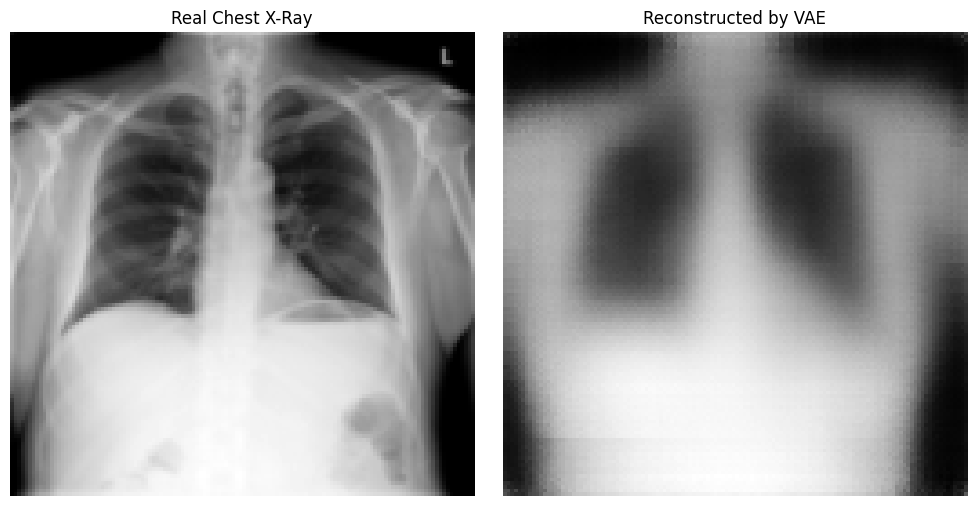

In [7]:
# Get real and reconstructed images
X, X_rec, _ = trainer.inference(test_dataloader)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(X[0].reshape(128, 128), cmap="gray")
ax1.set_title("Real Chest X-Ray")
ax1.axis('off')

ax2.imshow(X_rec[0].reshape(128, 128), cmap="gray")
ax2.set_title("Reconstructed by VAE")
ax2.axis('off')

plt.tight_layout()
plt.savefig("chestxray_vae_comparison.png", dpi=150)
plt.show()

## Experiment 2: Random Image Generation

Generate new images by sampling from the latent space.

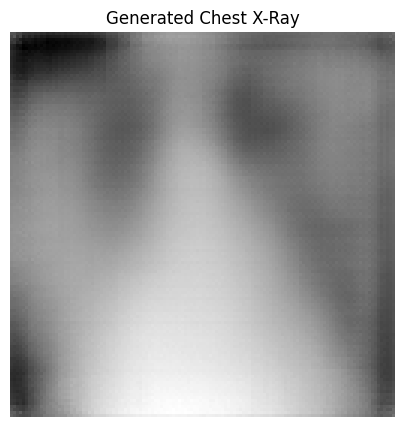

In [8]:
# Generate synthetic images
model = trainer.model
model.eval()

with torch.no_grad():
    # Sample from latent space
    z = torch.randn(1, model.hidden_dim).to(model.device)
    
    # Reshape for decoder (add spatial dims)
    z = z.unsqueeze(2).unsqueeze(3)
    
    # Generate image
    generated = model.decoder(z).detach().cpu().numpy()
    
    # Plot
    plt.figure(figsize=(5, 5))
    plt.imshow(generated[0].reshape(128, 128), cmap="gray")
    plt.title("Generated Chest X-Ray")
    plt.axis('off')
    plt.savefig("chestxray_vae_synthetic.png", dpi=150)
    plt.show()

## New Feature: Conditional VAE

Generate images conditioned on additional features (e.g., diagnosis codes).

In [ ]:
# Create dataset with conditional features
samples_with_conditions = [
    {
        "patient_id": "patient-0",
        "visit_id": "visit-0",
        "path": torch.rand(3, 128, 128),  # Dummy image
        "conditions": ["COVID-19", "pneumonia"],
        "label": 0,
    },
    {
        "patient_id": "patient-1",
        "visit_id": "visit-1",
        "path": torch.rand(3, 128, 128),
        "conditions": ["normal"],
        "label": 1,
    },
]

from pyhealth.datasets import SampleDataset

cond_dataset = SampleDataset(
    samples=samples_with_conditions,
    input_schema={"path": "tensor", "conditions": "sequence"},
    output_schema={"label": "binary"},
    dataset_name="conditional_demo",
)

# Conditional VAE model
cond_model = VAE(
    dataset=cond_dataset,
    feature_keys=["path"],
    label_key="label",
    mode="binary",
    input_type="image",
    input_channel=3,
    input_size=128,
    hidden_dim=64,
    conditional_feature_keys=["conditions"],
)

print("Conditional VAE created with embedding model for conditions")
print(f"Has embedding model: {hasattr(cond_model, 'embedding_model')}")

Label label vocab: {0: 0, 1: 1}


Processing samples:   0%|          | 0/2 [00:00<?, ?it/s]/home/ubuntu/PyHealth/pyhealth/processors/tensor_processor.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, dtype=self.dtype)
Processing samples: 100%|██████████| 2/2 [00:00<00:00, 350.72it/s]

Conditional VAE created with embedding model for conditions
Has embedding model: True


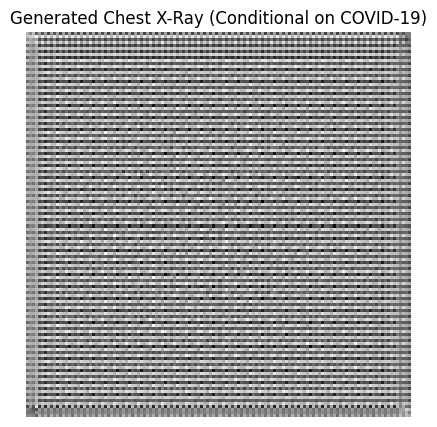

In [ ]:

# Generate conditional images
cond_model.eval()
with torch.no_grad():
    # Sample from latent space
    z = torch.randn(1, cond_model.hidden_dim).to(cond_model.device)

    # Create conditional data - need to process it like the dataset does
    # For sequence data, convert to tensor indices using the dataset's vocabulary
    vocab = cond_dataset.input_processors["conditions"].code_vocab
    condition_indices = [vocab.get(code, vocab.get("<unk>", 0)) for code in ["COVID-19"]]
    cond_data = {"conditions": torch.tensor(condition_indices, dtype=torch.long).unsqueeze(0)}  # (1, seq_len)

    # Now get embeddings
    cond_embeddings = cond_model.embedding_model(cond_data)
    cond_vec = cond_embeddings["conditions"].mean(dim=1)  # Average pooling for sequence

    # Reshape for decoder
    z = z.unsqueeze(2).unsqueeze(3)

    # Add conditional information to latent space
    z = z + cond_vec.unsqueeze(2).unsqueeze(3)

    # Generate image
    generated = cond_model.decoder(z).detach().cpu().numpy()

    # Plot - handle multi-channel output
    plt.figure(figsize=(5, 5))
    if generated[0].shape[0] == 3:  # RGB image
        img_to_show = generated[0].mean(axis=0)
    else:
        img_to_show = generated[0].reshape(128, 128)

    plt.imshow(img_to_show, cmap="gray")
    plt.title("Generated Chest X-Ray (Conditional on COVID-19)")
    plt.axis('off')
    plt.savefig("chestxray_vae_conditional.png", dpi=150)
    plt.show()

## Summary

The enhanced VAE now supports:
- **Image generation**: Unconditional and conditional
- **Flexible embeddings**: Integrated with PyHealth's EmbeddingModel

Key new parameters:
- `input_type`: 'image' or 'timeseries'
- `conditional_feature_keys`: List of keys for conditional generation

This enables more sophisticated generative models for medical image analysis and synthesis.

**Note**: Time-series modeling examples are available in the separate `timeseries_vae_modeling.ipynb` notebook.